In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

In [3]:
gen = pd.read_csv('Lawsuit.csv')

In [ ]:
# columns
# 1 Dept 1=Biochemistry/Molecular Biology 2=Physiology 3=Genetics 4=Pediatrics 5=Medicine 6=Surgery

# 2 Gender 1=Male, 0=Female

# 3 Clin 1=Primarily clinical emphasis, 0=Primarily research emphasis

# 4 Cert 1=Board certified, 0=not certified

# 5 Prate Publication rate (# publications on cv)/(# years between CV date and MD date)

# 6 Exper # years since obtaining MD

# 7 Rank 1=Assistant, 2=Associate, 3=Full professor (a proxy for productivity)

# 8 Sal94 Salary in academic year 1994

# 9 Sal95 Salary after increment to 1994

In [4]:
dept_names = ['Biochem/Mol Bio', 'Physiology', 'Genetics', 'Pediatrics', 'Medicine', 'Surgery']
dept_labels = dict(zip(range(1,7), dept_names))
gen['dept_labels'] = gen['Dept'].map(dept_labels)

In [5]:
x = gen.drop(columns=['ID','Sal94', 'Sal95', 'dept_labels'], axis=1)
y = gen['Sal94']

In [6]:
lm = LinearRegression().fit(x,y)

In [7]:
rsq = lm.score(x,y)
rsq

0.7843656040963467

In [8]:
d = dict(zip(x.columns, lm.coef_))
d

{'Dept': 28129.701291713394,
 'Gender': 10375.640311595878,
 'Clin': 5186.394339848151,
 'Cert': 15950.15099166876,
 'Prate': -6106.454803021705,
 'Exper': 3743.9402436681867,
 'Rank': 13918.913080522383}

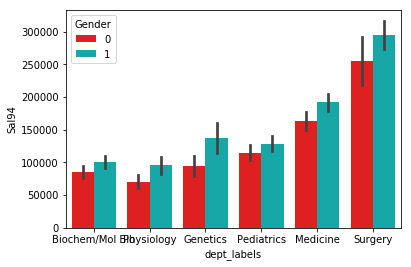

In [9]:
sns.barplot(x='dept_labels', y='Sal94', data=gen, hue='Gender', palette=["r", "c"])

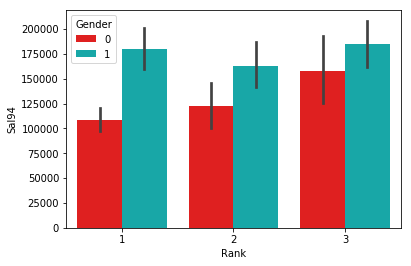

In [10]:
sns.barplot(x='Rank', y='Sal94', data=gen, hue='Gender', palette=["r", "c"])

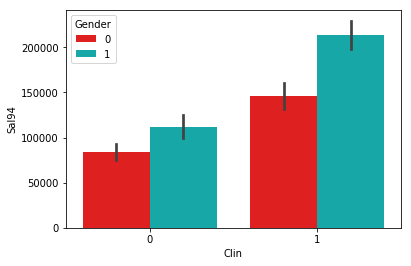

In [11]:
sns.barplot(x='Clin', y='Sal94', data=gen, hue='Gender', palette=["r", "c"])

In [12]:
fem = gen[gen['Gender']==0]
mal = gen[gen['Gender']==1]

xf = fem.drop(columns=['ID','Sal94', 'Sal95', 'Gender', 'dept_labels'], axis=1)
yf = fem['Sal94']

xm = mal.drop(columns=['ID','Sal94', 'Sal95', 'Gender', 'dept_labels'], axis=1)
ym = mal['Sal94']

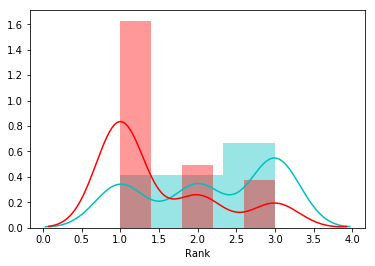

In [13]:
sns.distplot(mal['Rank'], color = 'c')
sns.distplot(fem['Rank'], color = 'r')

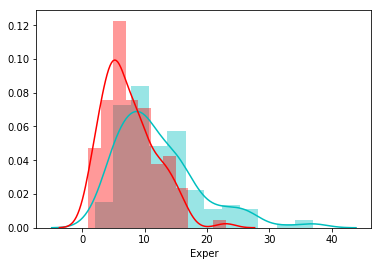

In [14]:
sns.distplot(mal['Exper'], color = 'c')
sns.distplot(fem['Exper'], color = 'r')

In [15]:
lm_f = LinearRegression().fit(xf, yf)
rsq_f = lm_f.score(xf,yf)
rsq_f

0.7668629883627263

In [16]:
df = dict(zip(xf.columns, lm_f.coef_))
df = sorted(df.items(), key = lambda x: np.abs(x[1]), reverse=True)
df

[('Dept', 22092.555462133776),
 ('Cert', 16091.098738572264),
 ('Clin', 15640.351680722444),
 ('Rank', 12381.937544353626),
 ('Exper', 4104.100510236611),
 ('Prate', -1773.2945473298569)]

In [17]:
lm_m = LinearRegression().fit(xm, ym)
rsq_m = lm_m.score(xm,ym)
rsq_m

0.7774750212017606

In [18]:
dm = dict(zip(xm.columns, lm_m.coef_))
dm = sorted(dm.items(), key = lambda x: np.abs(x[1]), reverse=True)

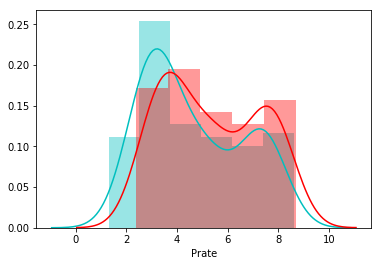

In [19]:
sns.distplot(mal['Prate'], color='c')
sns.distplot(fem['Prate'], color='r')

In [20]:
Prate_bin_map = dict(zip(range(0,9), range(1,10)))
Exper_bin_map = dict(zip(range(0,8), np.arange(5,45,5)))

In [21]:
# convert years of experience into 5-year bins
gen['Exper_bins'] = pd.cut(gen['Exper'], np.arange(0,41,5), labels=False)
gen['Exper_bins'] = gen['Exper_bins'].map(Exper_bin_map)

# convert publication # integer bins
gen['Prate_bins'] = pd.cut(gen['Prate'], np.arange(1,10), labels=False)
gen['Prate_bins'] = gen['Prate_bins'].map(Prate_bin_map)

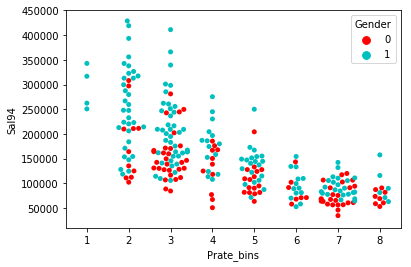

In [22]:
sns.swarmplot(x='Prate_bins', y='Sal94', data=gen, hue='Gender', palette=["r", "c", "y"])

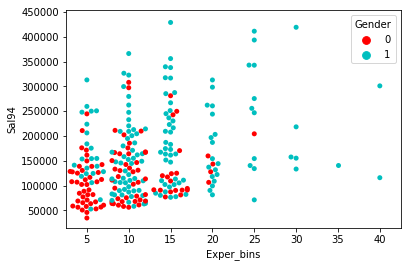

In [23]:
sns.swarmplot(x='Exper_bins', y='Sal94', data=gen, hue='Gender', palette=["r", "c", "y"])

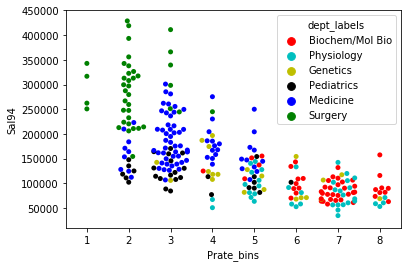

In [24]:
sns.swarmplot(x='Prate_bins', y='Sal94', data=gen, hue='dept_labels', palette=["r", "c", "y", 'k', 'b', 'g'])

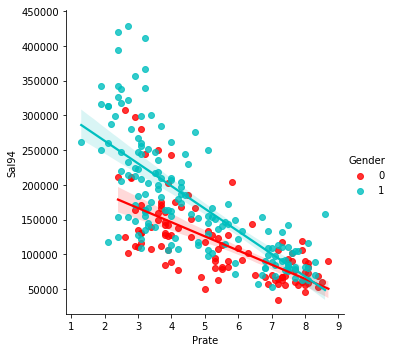

In [25]:
sns.lmplot(x="Prate", y="Sal94", hue="Gender",
               truncate=True, height=5, data=gen, palette=["r", "c"])

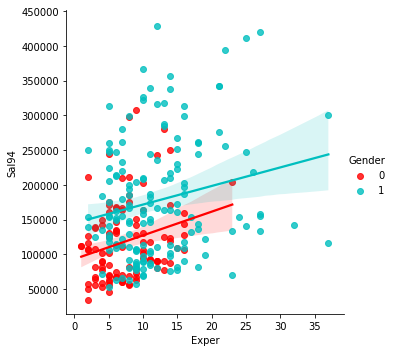

In [26]:
sns.lmplot(x="Exper", y="Sal94", hue="Gender",
               truncate=True, height=5, data=gen, palette=["r", "c"])

In [ ]:
gen_short = gen[['Gender', 'Prate', 'Exper', 'Sal94']]

In [ ]:
sns.pairplot(gen_short, hue="Gender", palette=["r", "c", "y"])

In [ ]:
sns.swarmplot(x='dept_labels', y='Prate', hue='Gender', data=gen, palette = ["r", "c", "y"])

In [ ]:
rp.summary_cont(gen['Sal94'])

In [ ]:
rp.summary_cont(gen.groupby(['Gender', 'Exper_bins']))['Sal94']

In [103]:
mal.Sal94.describe()

count       155.000000
mean     177338.761290
std       85930.539592
min       52582.000000
25%      109687.000000
50%      155006.000000
75%      231501.500000
max      428876.000000
Name: Sal94, dtype: float64

In [99]:
def create_survival_df(male_df, female_df, column, interval):
    surv_df = pd.DataFrame(columns = ['male', 'female'])
    for i in np.arange(0,male_df[column].max()+1, interval):
        surv_df.loc[i,'male'] = male_df[male_df[column]>=i].shape[0]/male_df.shape[0]
        surv_df.loc[i,'female'] = female_df[female_df[column]>=i].shape[0]/female_df.shape[0]
    surv_df.reset_index(inplace=True)
    return surv_df

In [153]:
surv_exper_df = create_survival_df(mal, fem, 'Exper', 1)
surv_sal94_df = create_survival_df(mal, fem, 'Sal94', 10000)

Text(0.5, 1.0, 'Survival Curve: Experience in years')

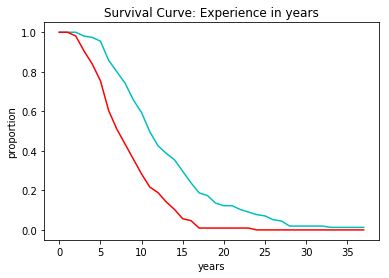

In [111]:
# survival curve
fig, ax = plt.subplots()
sns.lineplot(x='index', y='male', data=surv_exper_df, color='c', ax=ax)
sns.lineplot(x='index', y='female', data=surv_exper_df, color='r', ax=ax)
ax.set_xlabel('years')
ax.set_ylabel('proportion')
plt.title('Survival Curve: Experience in years')

Text(0.5, 1.0, 'Survival Curve: Salary')

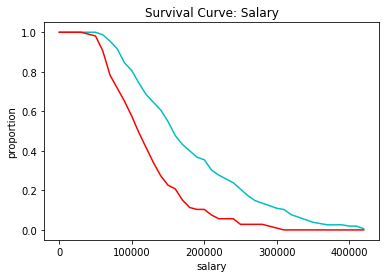

In [112]:
# survival curve
fig, ax = plt.subplots()
sns.lineplot(x='index', y='male', data=surv_sal94_df, color='c', ax=ax)
sns.lineplot(x='index', y='female', data=surv_sal94_df, color='r', ax=ax)
ax.set_xlabel('salary')
ax.set_ylabel('proportion')
plt.title('Survival Curve: Salary')

In [49]:
'''for each female, find the range of years of experience to find matched males'''
linked_exper = []
for f, frow in fem.iterrows():
    low = frow.Exper*.8
    high = frow.Exper*1.2
    matched_mal = mal[(mal.Exper < high) & (mal.Exper > low)]
    if matched_mal.shape[0]==0:
        continue

    for m, mrow in matched_mal.iterrows():
        linked_exper.append((frow.ID, mrow.ID))
linked_exper_df = pd.DataFrame(linked_exper, columns= ['female_id', 'male_id'])

In [127]:
# sample salary from men matched to women on years of experience only
all_samps_exper = pd.DataFrame()
all_props_exper = pd.DataFrame()
for i in range(0,1000):
    samp_df = linked_exper_df.sample(frac=1).drop_duplicates(subset = 'female_id')
    all_samps_exper.loc[:,i] = gen.loc[samp_df['male_id']].reset_index()['Sal94']
    
# create proportions for survival curve
    for ind in np.arange(0,gen['Sal94'].max()+1, 10000):
        all_props_exper.loc[ind,i] = all_samps_exper[all_samps_exper[i]>=ind].shape[0]/all_samps_exper.shape[0]
    
all_props_exper

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
10000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
20000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
30000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
40000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
60000,0.990385,0.942308,0.971154,0.971154,0.971154,0.990385,0.980769,1.000000,0.980769,0.980769,...,0.961538,0.971154,0.980769,0.971154,1.000000,0.980769,0.980769,0.961538,0.980769,0.971154
70000,0.961538,0.932692,0.961538,0.932692,0.942308,0.971154,0.971154,1.000000,0.971154,0.961538,...,0.951923,0.961538,0.961538,0.951923,0.980769,0.971154,0.951923,0.951923,0.951923,0.903846
80000,0.932692,0.913462,0.942308,0.913462,0.923077,0.951923,0.951923,0.980769,0.971154,0.932692,...,0.903846,0.951923,0.942308,0.923077,0.951923,0.951923,0.932692,0.932692,0.942308,0.903846
90000,0.884615,0.894231,0.884615,0.884615,0.894231,0.942308,0.903846,0.942308,0.923077,0.903846,...,0.855769,0.913462,0.923077,0.913462,0.932692,0.903846,0.903846,0.875000,0.913462,0.894231


In [157]:
# mins = all_props_exper.min(axis=1)
# maxes = all_props_exper.max(axis=1)
mins = all_props_exper.quantile(.025, axis=1)
maxes = all_props_exper.quantile(.975, axis=1)

Text(0.5, 1.0, 'Survival Curve: Salary, Matched on years of Experience')

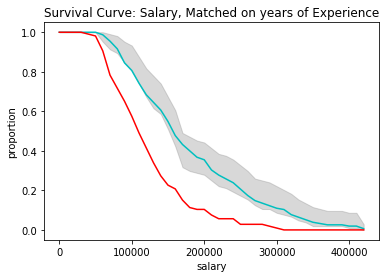

In [158]:
# survival curve
fig, ax = plt.subplots()
sns.lineplot(x='index', y='male', data=surv_sal94_df, color='c', ax=ax)
sns.lineplot(x='index', y='female', data=surv_sal94_df, color='r', ax=ax)
plt.fill_between(x=all_props_exper.index.values, y1=mins, y2=maxes, alpha=.3, color='gray')
ax.set_xlabel('salary')
ax.set_ylabel('proportion')
plt.title('Survival Curve: Salary, Matched on years of Experience')

In [146]:
gen['Sal94'].argmax()

/Users/djb326/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


238

In [148]:
fem.Exper.describe()

count    106.000000
mean       7.490566
std        4.166180
min        1.000000
25%        5.000000
50%        7.000000
75%       10.000000
max       23.000000
Name: Exper, dtype: float64